In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# DGI vs NAICS Group Errors, Anova, Etc
In hierarchical encoding, more general NAICS categories are worse than specific.  For DGI clusters, it's the opposite.  Why? 

Here, I look at error variance from various groupings of different granularities.  Which grouping scheme (DGI vs. NAICS standard) accounts for more variance in target rates?  This is another measure of how well the groups predict target rates.

See also https://www.peggykern.org/uploads/5/6/6/7/56678211/ftestformulas.pdf

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import importlib, os

In [3]:
import seaborn as sns

In [4]:
from sba_gnn.sba_gnn import sg_plot 
sg_plot.plot_defaults()

In [5]:
import matplotlib.pyplot as plt

## Import Data

In [6]:
sba_loans = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_transformed.parquet'))

In [7]:
sba_loans.columns

Index(['LoanNr_ChkDgt', 'Name', 'City', 'State', 'Zip', 'Bank', 'BankState',
       'NAICS', 'ApprovalDate', 'ApprovalFY', 'Term', 'NoEmp', 'NewExist',
       'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr',
       'LowDoc', 'ChgOffDate', 'DisbursementDate', 'DisbursementGross',
       'BalanceGross', 'MIS_Status', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv',
       'target', 'guaranteed_fract', 'new_business', 'urban_flag',
       'franchise_flag', 'NAICS_2', 'NAICS_sector', 'NAICS_sector_desc',
       'NAICS_num', 'dset', 'dset_naics_holdout', 'NAICS_5', 'NAICS_4',
       'NAICS_3', 'menc_NAICS', 'menc_NAICS_5', 'menc_NAICS_4', 'menc_NAICS_3',
       'menc_NAICS_sector', 'mhier_NAICS',
       'NS___Accommodation and Food Services',
       'NS___Administrative and Support and Waste Management and Remediation Services',
       'NS___Construction', 'NS___Health Care and Social Assistance',
       'NS___Manufacturing',
       'NS___Other Services (except Public Administra

In [12]:
embed_df = pd.read_parquet(Path(setup.temp_path).joinpath('63_DATA_embeddings_tsne_naics.parquet'))

In [13]:
hier_df = pd.read_parquet(Path(setup.temp_path).joinpath('65_DATA_dgi_mhier.parquet'))

In [14]:
naics_grp_col = ['NAICS_5', 'NAICS_4', 'NAICS_3', 'NAICS_sector']

In [15]:
naics_dgi_col = [c for c in embed_df.columns if c.startswith('cluster_')] 

In [54]:
loans_simplified = sba_loans[['LoanNr_ChkDgt', 'target', 'dset', 'dset_naics_holdout', 'NAICS',
                             'menc_NAICS', 'mhier_NAICS'] + naics_grp_col] \
    .merge(embed_df[['NAICS_orig'] + naics_dgi_col].rename(columns={'NAICS_orig':'NAICS'}),
           on='NAICS') \
    .merge(hier_df[['LoanNr_ChkDgt','menc_dgi']],on='LoanNr_ChkDgt')

In [17]:
loans_simplified.head()

,LoanNr_ChkDgt,target,dset,dset_naics_holdout,NAICS,NAICS_5,NAICS_4,NAICS_3,NAICS_sector,cluster_003,cluster_010,cluster_020,cluster_106,cluster_354,cluster_834,menc_dgi
0,1000014003,0,train,0,451120,45112,4511,451,44-45,2,2,2,32,222,300,0.231334
1,1000944000,0,train,0,451120,45112,4511,451,44-45,2,2,2,32,222,300,0.231334
2,1001095003,1,val,0,451120,45112,4511,451,44-45,2,2,2,32,222,300,0.231334
3,1004545002,0,train,0,451120,45112,4511,451,44-45,2,2,2,32,222,300,0.231334
4,1011395003,0,train,0,451120,45112,4511,451,44-45,2,2,2,32,222,300,0.231334


In [18]:
train_df = loans_simplified[loans_simplified['dset'] == 'train'].copy()

##### Metrics

In [19]:
metrics_df = pd.read_csv(Path(setup.temp_path).joinpath('80_REPORT_metrics_combined.csv'))

##### Group stats

In [20]:
naics_grp_stats_train = pd.read_csv(Path(setup.temp_path).joinpath('02_REPORT_naics_grp_stats_train.csv'))
naics_grp_stats = pd.read_csv(Path(setup.temp_path).joinpath('02_REPORT_naics_grp_stats_all.csv'))

In [21]:
dgi_grp_stats_train = pd.read_csv(Path(setup.temp_path).joinpath('82_REPORT_dgi_grp_stats_train.csv'))
dgi_grp_stats = pd.read_csv(Path(setup.temp_path).joinpath('82_REPORT_dgi_grp_stats_all.csv'))

## Compare Guessing Group Mean vs. Overal Mean
Sum of squares - differences from means

In [22]:
def ss_diff_means(data, group_col):
    N = len(data)
    k = len(data[group_col].drop_duplicates())
    
    grand_mean = data['target'].mean()

    group_means = data.groupby(group_col) \
        ['target'] \
        .agg(['count', 'mean']) \
        .set_axis(['n_group', 'group_mean'], axis=1) \
        .reset_index()
    
    data = data.merge(group_means, on=group_col)
    
    data['ss_grand_mean'] = (data['target'] - grand_mean)**2
    data['ss_grp_mean'] = (data['target'] - data['group_mean'])**2
    
    ss_grand_mean = data['ss_grand_mean'].sum()
    
    ss_grp_mean = data['ss_grp_mean'].sum()

    
    return pd.DataFrame({'N': [N], 'k': [k],
                         'ss_grand_mean': [ss_grand_mean], 
                         'ss_grp_mean':[ss_grp_mean]})
        
    

In [23]:
naics_mean_ss = pd.concat([ss_diff_means(train_df, c) for c in naics_grp_col],
                             keys=naics_grp_col)
naics_mean_ss

,,N,k,ss_grand_mean,ss_grp_mean
NAICS_5,0,436120,770,70987.750995,67119.534913
NAICS_4,0,436120,348,70987.750995,67697.467833
NAICS_3,0,436120,105,70987.750995,68520.985730
NAICS_sector,0,436120,20,70987.750995,70098.882943


In [24]:
dgi_mean_ss = pd.concat([ss_diff_means(train_df, c) for c in naics_dgi_col],
                             keys=naics_dgi_col)
dgi_mean_ss

,,N,k,ss_grand_mean,ss_grp_mean
cluster_003,0,436120,3,70987.750995,69727.314121
cluster_010,0,436120,10,70987.750995,69209.323115
cluster_020,0,436120,20,70987.750995,68774.499350
cluster_106,0,436120,105,70987.750995,68106.698570
cluster_354,0,436120,338,70987.750995,67585.670748
cluster_834,0,436120,757,70987.750995,67095.919079


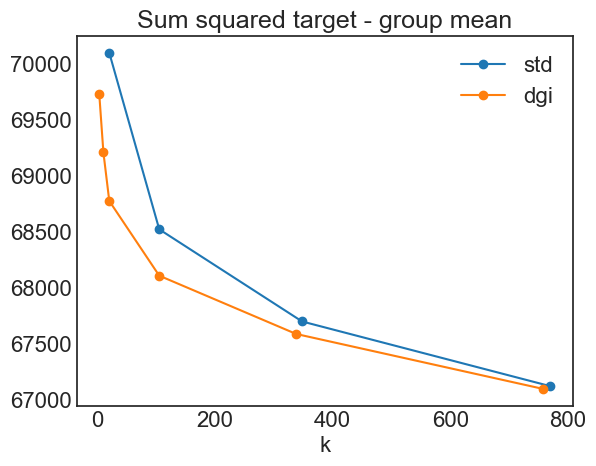

In [25]:
fig, ax = plt.subplots()
naics_mean_ss.plot(x='k', y='ss_grp_mean', label='std', ax=ax, style='o-')
dgi_mean_ss.plot(x='k', y='ss_grp_mean', label='dgi', ax=ax, style='o-')
plt.title('Sum squared target - group mean')
plt.show()

It appears the DGI group means are more similar than the overall mean to the target rates - this doesn't explain the results!

## Single-NAICS Groupings 
Which groups are essentially single NAICS?  

In [26]:
def single_code_stats(data, group_col):
    data_naics = data[['NAICS', group_col, 'target']] \
        .drop_duplicates('NAICS') \
        .reset_index()
    
    tot_naics = len(data_naics)
    
    data_naics_grp = data_naics.groupby(group_col) \
        ['target'] \
        .agg('count') \
        .reset_index()
    
    k = len(data_naics_grp)
    
    naics_1 = len(data_naics_grp[data_naics_grp['target'] == 1])
    
    return pd.DataFrame({'k': k,
                         'tot_naics': [tot_naics],
                         'single_naics': [naics_1],
                           'single_rate': [naics_1/tot_naics]})

In [27]:
single_rate_std = pd.concat([single_code_stats(train_df, c) for c in naics_grp_col],
                             keys=naics_grp_col)
single_rate_std

,,k,tot_naics,single_naics,single_rate
NAICS_5,0,770,1166,574,0.492281
NAICS_4,0,348,1166,93,0.079760
NAICS_3,0,105,1166,6,0.005146
NAICS_sector,0,20,1166,0,0.000000


In [28]:
single_rate_dgi = pd.concat([single_code_stats(train_df, c) for c in naics_dgi_col],
                             keys=naics_dgi_col)
single_rate_dgi

,,k,tot_naics,single_naics,single_rate
cluster_003,0,3,1166,0,0.000000
cluster_010,0,10,1166,0,0.000000
cluster_020,0,20,1166,0,0.000000
cluster_106,0,105,1166,10,0.008576
cluster_354,0,338,1166,113,0.096913
cluster_834,0,757,1166,572,0.490566


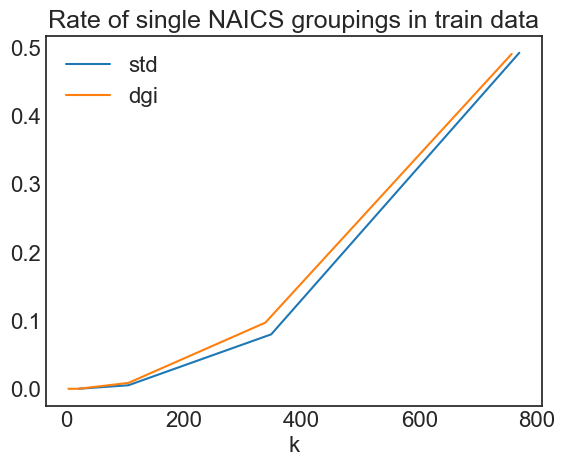

In [29]:
fig, ax = plt.subplots()
single_rate_std.plot(x='k', y='single_rate', label='std', ax=ax)
single_rate_dgi.plot(x='k', y='single_rate', label='dgi', ax=ax)
plt.title('Rate of single NAICS groupings in train data')
plt.show()

The rates are not terribly different.  The higher DGI rate is maybe consistent with the trends but this isn't a big difference

## Full ANOVA terms at Loan Level

In [30]:
def get_ss_info(data, group_col):
    N = len(data)
    k = len(data[group_col].drop_duplicates())
    
    grand_mean = data['target'].mean()
    
    group_means = data.groupby(group_col) \
        ['target'] \
        .agg(['count', 'mean']) \
        .set_axis(['n_group', 'group_mean'], axis=1) \
        .reset_index()
    
    #group_means = group_means[group_means['n_group'] > 1]
    
    group_means['ss_between'] = group_means['n_group'] * \
        (group_means['group_mean'] - grand_mean)**2
    
    ss_between = group_means['ss_between'].sum()
    ms_between = ss_between / (k - 1)
    
    base_var = data.merge(group_means, on=group_col) 
    base_var['ss_within'] = (base_var['target'] - base_var['group_mean'])**2
    
    ss_within =  base_var['ss_within'].sum()
    ms_within = ss_within / (N - k)
    
    F = ms_between / ms_within
    
    return pd.DataFrame({'F': [F], 'N': [N], 'k': [k],
                         'ss_between': [ss_between], 'ms_between': [ms_between],
                         'ss_within':[ss_within], 'ms_within':[ms_within],
                         'ss_tot': [ss_within + ss_between]})
    

In [31]:
ss_info_dgi = pd.concat([get_ss_info(train_df, c) for c in naics_dgi_col],
                         keys=naics_dgi_col)
ss_info_dgi

,,F,N,k,ss_between,ms_between,ss_within,ms_within,ss_tot
cluster_003,0,3941.769128,436120,3,1260.436874,630.218437,69727.314121,0.159882,70987.750995
cluster_010,0,1245.160090,436120,10,1778.427880,197.603098,69209.323115,0.158697,70987.750995
cluster_020,0,738.645139,436120,20,2213.251645,116.486929,68774.499350,0.157704,70987.750995
cluster_106,0,177.349277,436120,105,2881.052425,27.702427,68106.698570,0.156203,70987.750995
cluster_354,0,65.092254,436120,338,3402.080247,10.095194,67585.670748,0.155091,70987.750995
cluster_834,0,33.403171,436120,757,3891.831916,5.147926,67095.919079,0.154115,70987.750995


In [32]:
ss_info_naics = pd.concat([get_ss_info(train_df, c) for c in naics_grp_col],
                         keys=naics_grp_col)
ss_info_naics

,,F,N,k,ss_between,ms_between,ss_within,ms_within,ss_tot
NAICS_5,0,32.626764,436120,770,3868.216083,5.030190,67119.534913,0.154174,70987.750995
NAICS_4,0,61.036651,436120,348,3290.283162,9.482084,67697.467833,0.155351,70987.750995
NAICS_3,0,150.928868,436120,105,2466.765265,23.718897,68520.985730,0.157153,70987.750995
NAICS_sector,0,291.044023,436120,20,888.868052,46.782529,70098.882943,0.160740,70987.750995


Text(0.5, 1.0, 'Mean square within group err')

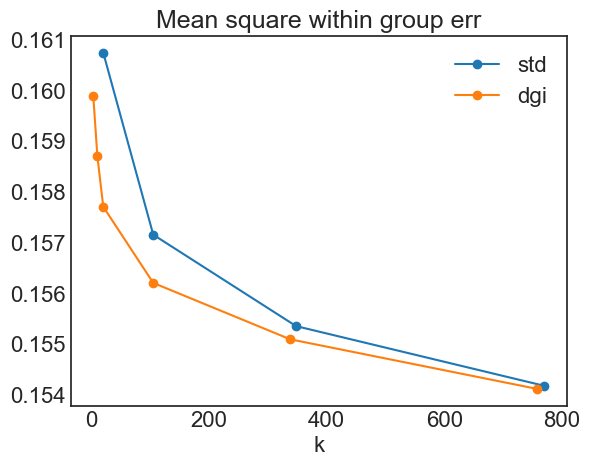

In [33]:
fig, ax = plt.subplots()
ss_info_naics.plot(x='k', y='ms_within', ax=ax, label='std', style='o-')
ss_info_dgi.plot(x='k', y='ms_within', ax=ax, label='dgi', style='o-')
ax.set_title('Mean square within group err')

Text(0.5, 1.0, 'Mean square between group err')

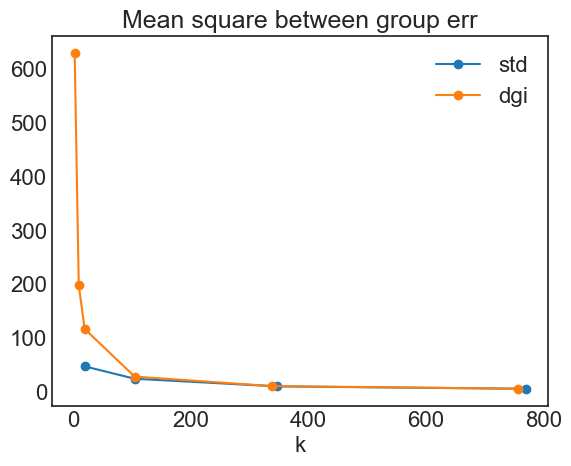

In [34]:
fig, ax = plt.subplots()
ss_info_naics.plot(x='k', y='ms_between', ax=ax, label='std', style='o-')
ss_info_dgi.plot(x='k', y='ms_between', ax=ax, label='dgi', style='o-')
ax.set_title('Mean square between group err')

Text(0.5, 1.0, 'Sum square within group err')

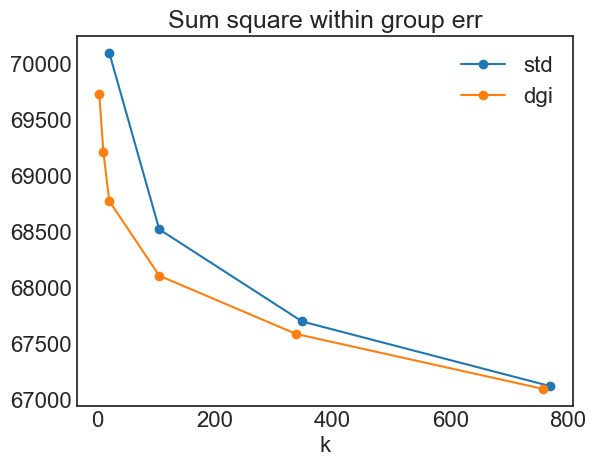

In [35]:
fig, ax = plt.subplots()
ss_info_naics.plot(x='k', y='ss_within', ax=ax, label='std', style='o-')
ss_info_dgi.plot(x='k', y='ss_within', ax=ax, label='dgi', style='o-')
ax.set_title('Sum square within group err')

Text(0.5, 1.0, 'F scores')

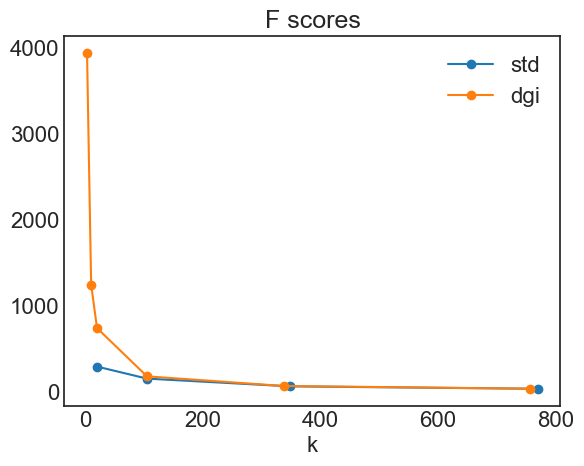

In [36]:
fig, ax = plt.subplots()
ss_info_naics.plot(x='k', y='F', ax=ax, label='std', style='o-')
ss_info_dgi.plot(x='k', y='F', ax=ax, label='dgi', style='o-')
ax.set_title('F scores')

## NAICS level

In [37]:
naics_base = train_df.drop_duplicates('NAICS').drop(columns='target') \
   .merge(train_df.groupby('NAICS')['target'].agg('mean').reset_index(),
          on='NAICS')


In [38]:
ss_info_dgi_base = pd.concat([get_ss_info(naics_base, c) for c in naics_dgi_col],
                         keys=naics_dgi_col)
ss_info_dgi_base

,,F,N,k,ss_between,ms_between,ss_within,ms_within,ss_tot
cluster_003,0,124.986768,1166,3,4.073598,2.036799,18.952384,0.016296,23.025982
cluster_010,0,35.783352,1166,10,5.017097,0.557455,18.008885,0.015579,23.025982
cluster_020,0,20.305228,1166,20,5.799329,0.305228,17.226653,0.015032,23.025982
cluster_106,0,5.832836,1166,105,8.375977,0.080538,14.650005,0.013808,23.025982
cluster_354,0,2.889023,1166,338,12.443441,0.036924,10.582541,0.012781,23.025982
cluster_834,0,3.027121,1166,757,19.534744,0.025840,3.491238,0.008536,23.025982


In [39]:
ss_info_naics_base = pd.concat([get_ss_info(naics_base, c) for c in naics_grp_col],
                         keys=naics_grp_col)
ss_info_naics_base

,,F,N,k,ss_between,ms_between,ss_within,ms_within,ss_tot
NAICS_5,0,0.996283,1166,770,15.179874,0.019740,7.846108,0.019813,23.025982
NAICS_4,0,1.971927,1166,348,10.488025,0.030225,12.537957,0.015328,23.025982
NAICS_3,0,4.525248,1166,105,7.075240,0.068031,15.950742,0.015034,23.025982
NAICS_sector,0,6.029470,1166,20,2.092606,0.110137,20.933376,0.018266,23.025982


<Axes: xlabel='k'>

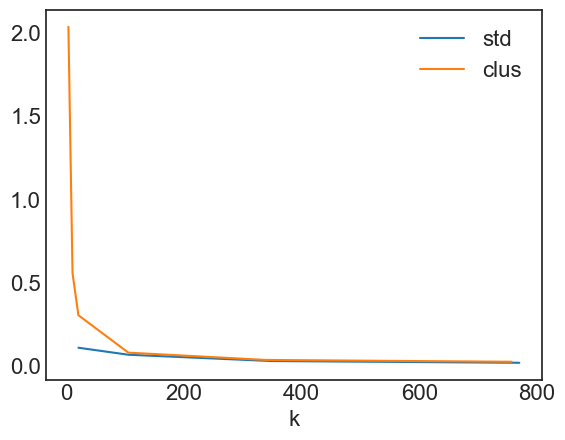

In [40]:
fig, ax = plt.subplots()
ss_info_naics_base.plot(x='k', y='ms_between', ax=ax, label='std')
ss_info_dgi_base.plot(x='k', y='ms_between', ax=ax, label='clus')

## Holdout Cases
Do the plots for holdout cases

In [41]:
test_ho_df = loans_simplified[loans_simplified['dset_naics_holdout'] == 1].copy()

In [42]:
ss_info_dgi_ho = pd.concat([get_ss_info(test_ho_df, c) for c in naics_dgi_col],
                         keys=naics_dgi_col)
ss_info_dgi_ho

,,F,N,k,ss_between,ms_between,ss_within,ms_within,ss_tot
cluster_003,0,1002.357517,65052,3,289.193143,144.596572,9383.740064,0.144256,9672.933207
cluster_010,0,290.640205,65052,10,373.971721,41.552413,9298.961487,0.142969,9672.933207
cluster_020,0,173.993678,65052,18,420.807477,24.753381,9252.125730,0.142266,9672.933207
cluster_106,0,66.381653,65052,55,505.582856,9.362645,9167.350352,0.141043,9672.933207
cluster_354,0,43.108463,65052,99,590.719257,6.027748,9082.213951,0.139827,9672.933207
cluster_834,0,35.900176,65052,121,601.845609,5.015380,9071.087598,0.139703,9672.933207


In [43]:
ss_info_naics_ho = pd.concat([get_ss_info(test_ho_df, c) for c in naics_grp_col],
                         keys=naics_grp_col)
ss_info_naics_ho

,,F,N,k,ss_between,ms_between,ss_within,ms_within,ss_tot
NAICS_5,0,36.777022,65052,119,605.975009,5.135381,9066.958198,0.139636,9672.933207
NAICS_4,0,38.076965,65052,106,560.935361,5.342242,9111.997846,0.140301,9672.933207
NAICS_3,0,37.784223,65052,61,326.043568,5.434059,9346.889639,0.143818,9672.933207
NAICS_sector,0,88.761546,65052,18,219.346113,12.902713,9453.587094,0.145364,9672.933207


Text(0.5, 0.98, 'Holdout cases')

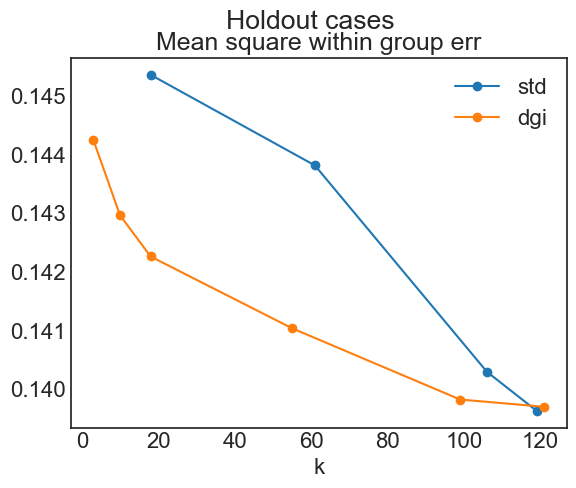

In [44]:
fig, ax = plt.subplots()
ss_info_naics_ho.plot(x='k', y='ms_within', ax=ax, label='std', style='o-')
ss_info_dgi_ho.plot(x='k', y='ms_within', ax=ax, label='dgi', style='o-')
ax.set_title('Mean square within group err')
fig.suptitle('Holdout cases')

Text(0.5, 0.98, 'Holdout cases')

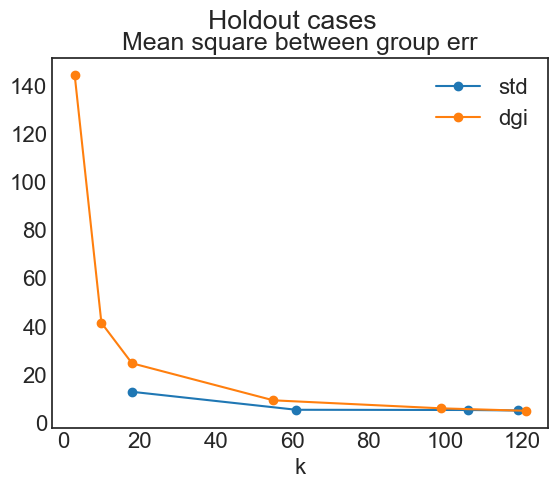

In [45]:
fig, ax = plt.subplots()
ss_info_naics_ho.plot(x='k', y='ms_between', ax=ax, label='std', style='o-')
ss_info_dgi_ho.plot(x='k', y='ms_between', ax=ax, label='dgi', style='o-')
ax.set_title('Mean square between group err')
fig.suptitle('Holdout cases')

Text(0.5, 0.98, 'Holdout cases')

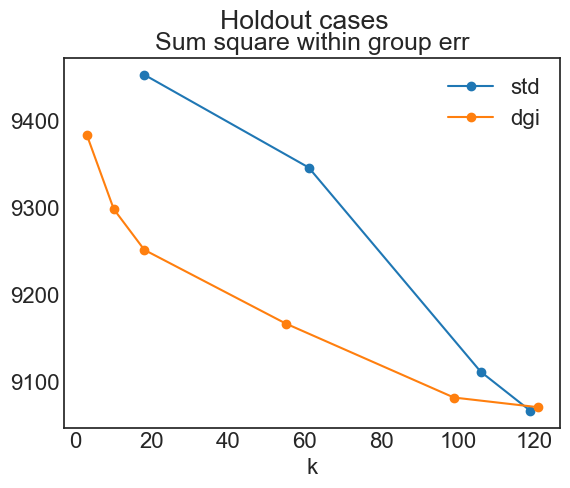

In [46]:
fig, ax = plt.subplots()
ss_info_naics_ho.plot(x='k', y='ss_within', ax=ax, label='std', style='o-')
ss_info_dgi_ho.plot(x='k', y='ss_within', ax=ax, label='dgi', style='o-')
ax.set_title('Sum square within group err')
fig.suptitle('Holdout cases')

Text(0.5, 0.98, 'Holdout cases')

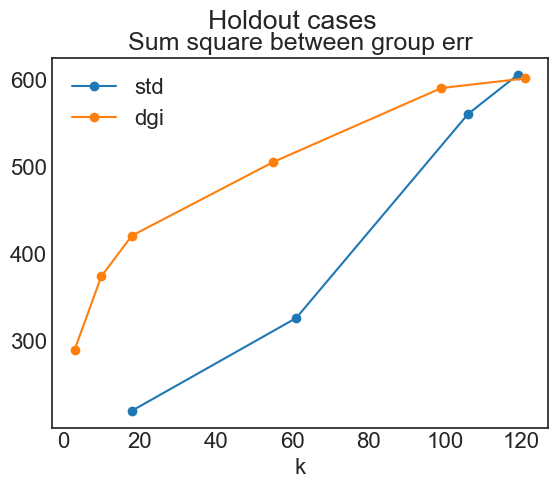

In [47]:
fig, ax = plt.subplots()
ss_info_naics_ho.plot(x='k', y='ss_between', ax=ax, label='std', style='o-')
ss_info_dgi_ho.plot(x='k', y='ss_between', ax=ax, label='dgi', style='o-')
ax.set_title('Sum square between group err')
fig.suptitle('Holdout cases')

Seemingly, DGI provides a better estimate of the target rate compared to NAICS standard groups

## Holdout cases - Model Levels Errors
Look at how well the holdout cases align with the group means

In [48]:
def get_ss_info_holdout(data, group_col):
    N = len(data)
    k = len(data[group_col].drop_duplicates())
    
    grand_mean = data[data['dset'] == 'train']['target'].mean()
    
    group_means_train = data[data['dset'] == 'train'] \
        .groupby(group_col) \
        ['target'] \
        .agg(['mean']) \
        .set_axis(['group_mean'], axis=1) \
        .reset_index()
    
    group_means_ho = data[data['dset_naics_holdout'] == 1] \
        .groupby(group_col) \
        ['target'] \
        .agg(['count']) \
        .set_axis(['n_group'], axis=1) \
        .reset_index()
    
    group_means= group_means_train.merge(group_means_ho, on=group_col)
    
    group_means['ss_between'] = group_means['n_group'] * \
        (group_means['group_mean'] - grand_mean)**2
    
    ss_between = group_means['ss_between'].sum()
    ms_between = ss_between / (k - 1)
    
    base_var = data.merge(group_means, on=group_col) 
    base_var['ss_within'] = (base_var['target'] - base_var['group_mean'])**2
    
    ss_within =  base_var['ss_within'].sum()
    ms_within = ss_within / (N - k)
    
    F = ms_between / ms_within
    
    return pd.DataFrame({'F': [F], 'N': [N], 'k': [k],
                         'ss_between': [ss_between], 'ms_between': [ms_between],
                         'ss_within':[ss_within], 'ms_within':[ms_within],
                         'ss_tot': [ss_within + ss_between]})
    

In [49]:
ss_info_dgi_ho_2 = pd.concat([get_ss_info_holdout(loans_simplified, c) for c in naics_dgi_col],
                         keys=naics_dgi_col)
ss_info_dgi_ho_2

,,F,N,k,ss_between,ms_between,ss_within,ms_within,ss_tot
cluster_003,0,891.778172,688081,3,283.047007,141.523503,109196.672699,0.158698,109479.719706
cluster_010,0,284.083439,688081,10,402.817662,44.757518,108406.002975,0.157551,108808.820637
cluster_020,0,130.179157,688081,20,386.777736,20.356723,107595.312835,0.156375,107982.090572
cluster_106,0,43.681521,688081,106,529.028771,5.038369,79353.282514,0.115343,79882.311285
cluster_354,0,30.069907,688081,354,605.381985,1.714963,39222.816762,0.057033,39828.198747
cluster_834,0,10.584135,688081,834,193.830049,0.232689,15108.925687,0.021985,15302.755736


In [50]:
ss_info_naics_ho_2 = pd.concat([get_ss_info_holdout(loans_simplified, c) for c in naics_grp_col],
                         keys=naics_grp_col)
ss_info_naics_ho_2

,,F,N,k,ss_between,ms_between,ss_within,ms_within,ss_tot
NAICS_5,0,13.756495,688081,834,175.498781,0.210683,10525.292124,0.015315,10700.790905
NAICS_4,0,22.444826,688081,354,375.439021,1.063567,32588.512999,0.047386,32963.952020
NAICS_3,0,27.686991,688081,106,315.658310,3.006270,74700.726609,0.108581,75016.384919
NAICS_sector,0,32.583258,688081,20,99.007629,5.210928,110039.219160,0.159927,110138.226789


Text(0.5, 0.98, 'Holdout cases- relative to train')

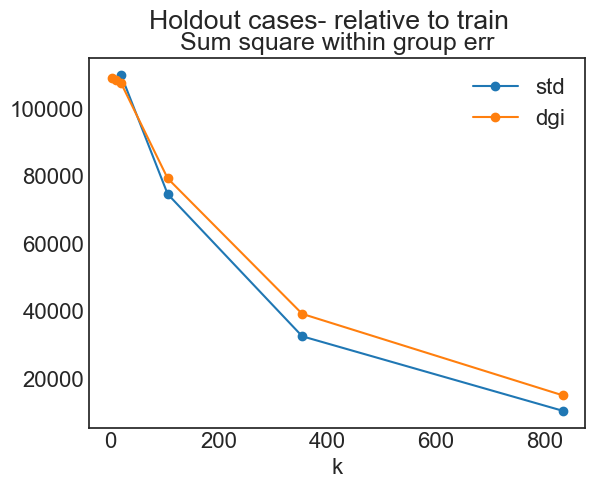

In [51]:
fig, ax = plt.subplots()
ss_info_naics_ho_2.plot(x='k', y='ss_within', ax=ax, label='std', style='o-')
ss_info_dgi_ho_2.plot(x='k', y='ss_within', ax=ax, label='dgi', style='o-')
ax.set_title('Sum square within group err')
fig.suptitle('Holdout cases- relative to train')

Text(0.5, 0.98, 'Holdout cases- relative to train')

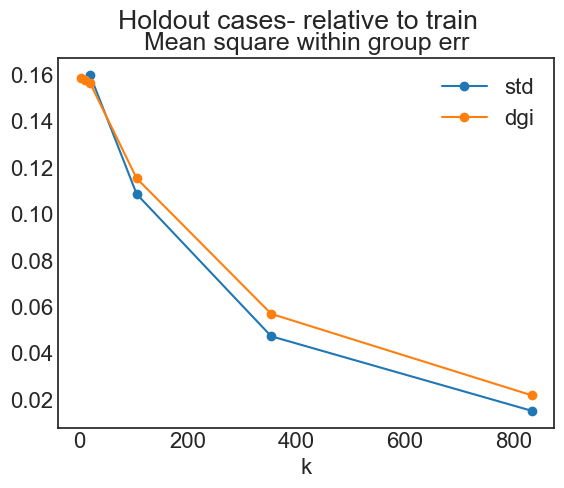

In [52]:
fig, ax = plt.subplots()
ss_info_naics_ho_2.plot(x='k', y='ms_within', ax=ax, label='std', style='o-')
ss_info_dgi_ho_2.plot(x='k', y='ms_within', ax=ax, label='dgi', style='o-')
ax.set_title('Mean square within group err')
fig.suptitle('Holdout cases- relative to train')

## Mean Encodings

Look at variance explained by the target encodings

In [55]:
loans_simplified.columns

Index(['LoanNr_ChkDgt', 'target', 'dset', 'dset_naics_holdout', 'NAICS',
       'menc_NAICS', 'mhier_NAICS', 'NAICS_5', 'NAICS_4', 'NAICS_3',
       'NAICS_sector', 'cluster_003', 'cluster_010', 'cluster_020',
       'cluster_106', 'cluster_354', 'cluster_834', 'menc_dgi'],
      dtype='object')

In [61]:
simp_train = loans_simplified[loans_simplified['dset'] == 'train']
simp_test = loans_simplified[loans_simplified['dset_naics_holdout'] == 0]
simp_holdout = loans_simplified[loans_simplified['dset_naics_holdout'] == 1]

In [75]:
# Functions to get ANOVA for mean encodings
def ss_diff_means_enc(data, enc_col):
    
    data = data.copy()
    N = len(data)
    k = len(data['NAICS'].drop_duplicates())
    
    grand_mean = data['target'].mean()
    
    data['ss_grand_mean'] = (data['target'] - grand_mean)**2
    data['ss_grp_mean'] = (data['target'] - data[enc_col])**2
    
    ss_grand_mean = data['ss_grand_mean'].sum()
    ss_grp_mean = data['ss_grp_mean'].sum()

    return pd.DataFrame({'N': [N], 'k': [k],
                         'ss_grand_mean': [ss_grand_mean], 
                         'ss_grp_mean':[ss_grp_mean],
                          'value_mean':data[enc_col].mean(),
                        'value_std':data[enc_col].std(),
                        'target_mean':data['target'].mean()})
        
    

In [76]:
enc_cols = ['menc_NAICS', 'mhier_NAICS', 'menc_dgi']
train_menc_ss = pd.concat([ss_diff_means_enc(simp_train, c) 
                           for c in enc_cols],
                          keys = enc_cols) \
    .reset_index(level=0) \
    .rename(columns={'level_0':'type'}) \
    .reset_index(drop=True)
train_menc_ss


,type,N,k,ss_grand_mean,ss_grp_mean,value_mean,value_std,target_mean
0,menc_NAICS,436120,1166,70987.750995,66876.863854,0.205211,0.096038,0.204655
1,mhier_NAICS,436120,1166,70987.750995,66856.380636,0.204696,0.096976,0.204655
2,menc_dgi,436120,1166,70987.750995,67109.778758,0.204727,0.094044,0.204655


In [77]:
enc_cols = ['menc_NAICS', 'mhier_NAICS', 'menc_dgi']
ho_menc_ss = pd.concat([ss_diff_means_enc(simp_holdout, c) 
                           for c in enc_cols],
                          keys = enc_cols) \
    .reset_index(level=0) \
    .rename(columns={'level_0':'type'}) \
    .reset_index(drop=True)
ho_menc_ss


,type,N,k,ss_grand_mean,ss_grp_mean,value_mean,value_std,target_mean
0,menc_NAICS,65052,131,9672.933207,9707.161979,0.204655,0.000000,0.181716
1,mhier_NAICS,65052,131,9672.933207,9547.323295,0.196476,0.082249,0.181716
2,menc_dgi,65052,131,9672.933207,9617.701853,0.175107,0.085193,0.181716


In [78]:
enc_cols = ['menc_NAICS', 'mhier_NAICS', 'menc_dgi']
test_menc_ss = pd.concat([ss_diff_means_enc(simp_test, c) 
                           for c in enc_cols],
                          keys = enc_cols) \
    .reset_index(level=0) \
    .rename(columns={'level_0':'type'}) \
    .reset_index(drop=True)
test_menc_ss

,type,N,k,ss_grand_mean,ss_grp_mean,value_mean,value_std,target_mean
0,menc_NAICS,623029,1180,101624.289486,95877.315214,0.205204,0.096013,0.205234
1,mhier_NAICS,623029,1180,101624.289486,95856.783222,0.204681,0.096954,0.205234
2,menc_dgi,623029,1180,101624.289486,96203.336796,0.204705,0.093990,0.205234


In [81]:
enc_ss_all = pd.concat([train_menc_ss, test_menc_ss, ho_menc_ss],
                       keys=['train', 'test', 'holdout']) \
    .reset_index(level=0) \
    .rename(columns={'level_0':'dataset'}) \
    .reset_index(drop=True)

In [82]:
enc_ss_all.to_csv(Path(setup.temp_path).joinpath('83_REPORT_ss_encodings.csv'), index=False)